In [353]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm, gmean, cauchy
import seaborn as sns
from datetime import datetime, timedelta

%matplotlib inline

In [300]:
def import_stock_data(tickers, start = '2010-1-1', end = datetime.today().strftime('%Y-%m-%d')):
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = wb.DataReader(t, data_source='yahoo', start = start)['Adj Close']
    return(data)

In [301]:
data = import_stock_data(['AMD','NVDA','M','^GSPC'])

In [202]:
def log_returns(data):
    return (np.log(1+data.pct_change()))

In [203]:
log_return = log_returns(data)

In [204]:
def drift_calc(data, return_type='log'):
    if return_type=='log':
        lr = log_returns(data)
    elif return_type=='simple':
        lr = simple_returns(data)
    u = lr.mean()
    var = lr.var()
    drift = u-(0.5*var)
    try:
        return drift.values
    except:
        return drift

In [205]:
drift = drift_calc(data)

In [206]:
stdev = log_returns(data).std().values

In [207]:
def get_tickers(data):
    tickers = [i for i in data.columns]
    return tickers
tickers=get_tickers(data)
tickers

['AMD', 'NVDA', 'M', '^GSPC']

In [208]:
def probs_find(predicted, higherthan, on = 'value'):
    if on == 'return':
        predicted0 = predicted.iloc[0,0]
        predicted = predicted.iloc[-1]
        predList = list(predicted)
        over = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 >= higherthan]
        less = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 < higherthan]
    elif on == 'value':
        predicted = predicted.iloc[-1]
        predList = list(predicted)
        over = [i for i in predList if i >= higherthan]
        less = [i for i in predList if i < higherthan]
    else:
        print("'on' must be either value or return")
    return (len(over)/(len(over)+len(less)))

In [356]:
data.index[0] +timedelta(days=1)

Timestamp('2010-01-05 00:00:00')

In [400]:
data.shape

(2609, 4)

In [399]:
data.index[-1]

Timestamp('2020-05-14 00:00:00')

In [397]:
def list_dates(firstdate, length):
    dates = []
    for i in range(1,length):
        dates.append(datetime.strptime(firstdate, "%Y-%m-%d")+timedelta(days=i))
    return dates

In [401]:
pd.DataFrame(list_dates('2010-1-5',2609))

,0
0,2010-01-06
1,2010-01-07
2,2010-01-08
3,2010-01-09
4,2010-01-10
...,...
2603,2017-02-21
2604,2017-02-22
2605,2017-02-23
2606,2017-02-24


In [365]:
datetime.strptime("2010-1-1",)

TypeError: strptime() takes exactly 2 arguments (1 given)

In [209]:
def montecarlo_cholesky(tickers, days, iterations, show_hist = False, show_line = False, show_stats=True):
    #Get tickers and number of tickers involved in this portfolio
    data = import_stock_data(tickers)
    ticks = get_tickers(data)
    numstocks = len(ticks)
    
    #Basic information and data
    log_return = log_returns(data)
    
    #Brownian motion component: drif
    drift = drift_calc(data)
    stdev = log_returns(data).std().values
    
    #Cholesky decomposition
    covari = log_return.cov()
    chol = np.linalg.cholesky(covari)
    
    #Generate uncorralated random variables and use cholesky decomposition to correlate them
    uncorr_x = norm.ppf(np.random.rand(numstocks,iterations*days))
    corr_x = np.dot(chol, uncorr_x)
    
    #Calculate daily return
    corr_2 = np.zeros_like(corr_x)
    for i in range(numstocks):
        corr_2[i] = np.exp(drift[i] + corr_x[i])
    simulatedDF = []    
    #For every stock, calculate the returns
    for s in range(len(ticks)):
        ret_reshape = corr_2[s]
        ret_reshape = ret_reshape.reshape(days,iterations)
        price_list = np.zeros_like(ret_reshape)
        price_list[0] = data.iloc[-1,s]
        #Calculate returns for the s stock
        for t in range(1,days):
            price_list[t] = price_list[t-1]*ret_reshape[t]
        
        #Create dataframe for this run, input the name of stock and load
        y = pd.DataFrame(price_list)   
        y['ticker'] = tickers[s]
        cols = y.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        y = y[cols]
        simulatedDF.append(y)
        
        #plotting
        if show_hist == True:
            x = pd.DataFrame(price_list).iloc[-1]
            fig, ax = plt.subplots(1,2, figsize=(14,4))
            sns.distplot(x, ax=ax[0],axlabel="Stock Price")
            sns.distplot(x, hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
            plt.xlabel("Stock Price")
            plt.show()
        if show_line == True:
            y = pd.DataFrame(price_list[:,0:10]).plot(figsize=(15,6))
        
        if show_stats == True:
        #Printing basic stats
            print(ticks[s])
            print(f"Days: {days}")
            print(f"Expected Value: ${round(pd.DataFrame(price_list).iloc[-1].mean(),2)}")
            print(f"Return: {round(100*(pd.DataFrame(price_list).iloc[-1].mean()-price_list[0,1])/pd.DataFrame(price_list).iloc[-1].mean(),2)}%")
            print(f"Probability of Breakeven: {probs_find(pd.DataFrame(price_list),0, on='return')}")
   
        
    simulatedDF = pd.concat(simulatedDF)
    return(simulatedDF)

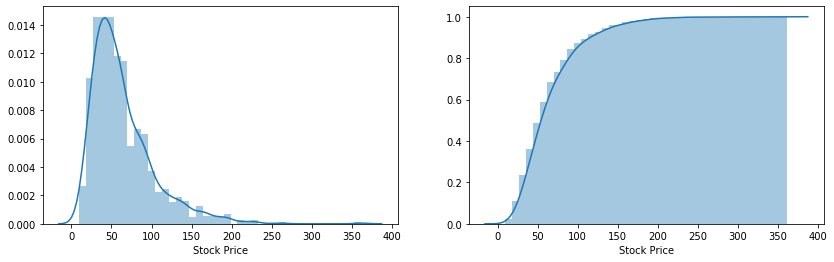

AMD
Days: 252
Expected Value: $63.72
Return: 14.45%
Probability of Breakeven: 0.493


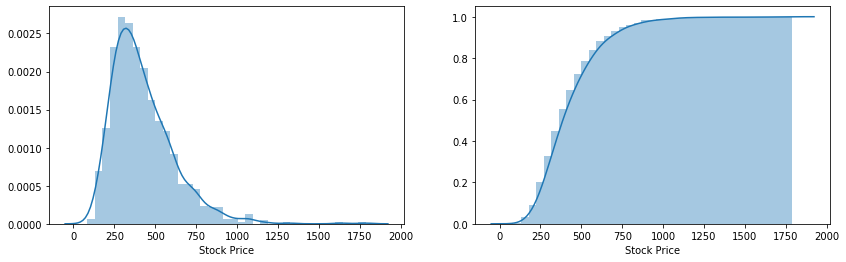

NVDA
Days: 252
Expected Value: $423.5
Return: 24.15%
Probability of Breakeven: 0.659


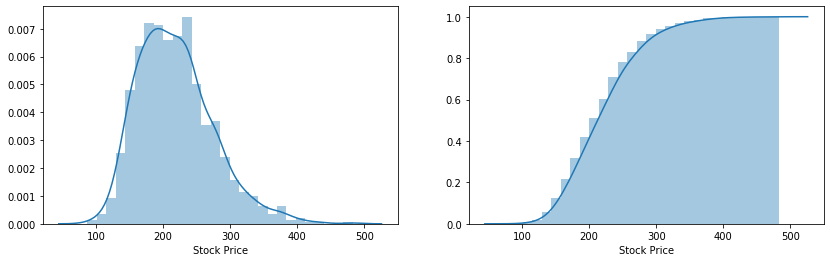

MSFT
Days: 252
Expected Value: $218.58
Return: 17.41%
Probability of Breakeven: 0.721


In [210]:
x = montecarlo_cholesky(['AMD','NVDA','MSFT'], days=252, iterations=1000, show_hist=True)

In [350]:
x

,ticker,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
0,AMD,54.509998,54.509998,54.509998,54.509998,54.509998,54.509998,54.509998,54.509998,54.509998,...,54.509998,54.509998,54.509998,54.509998,54.509998,54.509998,54.509998,54.509998,54.509998,54.509998
1,AMD,53.015095,54.711146,56.778386,55.702164,54.357926,52.280453,57.196224,53.860869,53.539799,...,54.732172,53.641843,52.665935,52.874490,53.125532,57.207236,54.129739,56.149725,55.985028,53.096577
2,AMD,52.729502,55.228774,54.937525,56.153171,52.862743,53.130926,60.929705,53.442693,57.494772,...,53.205986,51.880650,50.495984,52.666027,53.380144,59.266854,55.788249,54.727774,58.944500,51.789272
3,AMD,53.419004,57.512549,56.410159,54.668628,52.155036,54.137372,63.281893,54.150595,57.826563,...,49.236869,53.112498,51.648714,51.652509,56.322912,58.439508,58.382923,54.365327,62.408945,52.385191
4,AMD,53.722445,60.601505,55.516652,52.658766,49.930499,53.898897,63.018510,58.986712,60.869060,...,47.507652,53.614445,53.549100,52.177026,53.211725,57.776419,55.340797,52.068459,67.081590,49.295198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,MSFT,308.719837,230.693507,197.671598,205.269405,378.385936,359.222898,224.594011,230.383630,186.078567,...,196.614285,170.054019,191.619564,182.064160,192.752542,196.831804,166.474828,324.389586,218.308482,167.230422
248,MSFT,304.787418,229.870607,197.634728,209.793390,387.642992,364.841377,228.916730,231.745322,191.116326,...,198.271637,167.915572,190.478077,176.527140,190.923048,194.409457,164.825356,318.252320,224.049681,167.656615
249,MSFT,315.541856,232.300655,194.031260,214.719600,392.293400,366.508010,222.748270,229.736551,188.914649,...,195.941060,164.112683,188.919048,171.963962,193.759207,194.506314,162.887420,320.796242,225.667207,169.803355
250,MSFT,314.133107,234.024498,189.395379,212.987272,393.110766,374.369286,221.537098,229.342865,192.584948,...,193.982292,168.917410,188.119880,170.756097,192.781373,193.739007,163.123830,316.021421,225.075205,167.139927


In [212]:
data.iloc[-1]

AMD        54.509998
NVDA      321.220001
M           5.010000
^GSPC    2852.500000
Name: 2020-05-14 00:00:00, dtype: float64

## Sharpe Ratio

In [143]:
def market_data_combination(data, mark_ticker = "^GSPC", start='2010-1-1'):
    ticks = get_tickers(data)
    if mark_ticker in ticks:
        ann_return = np.exp(log_returns(data).mean()*252).values-1
    else:
        market_data = import_stock_data(mark_ticker, start)
        market_rets = log_returns(market_data).dropna()
        ann_return = np.exp(market_rets.mean()*252).values-1
        data = data.merge(market_data, left_index=True, right_index=True)
    return data, ann_return

In [159]:
a,b=market_data_combination(data)

In [221]:
def beta_sharpe(data, mark_ticker = "^GSPC", start='2010-1-1', riskfree = 0.025, riskpremium = 0.05):
    # Beta
    dd, mark_ret = market_data_combination(data, mark_ticker, start) #load data and annual returns
    log_ret = log_returns(dd) # create the logarithmic returns of the data
    covar = log_ret.cov()*252 #Annualized covariance matrix 
    covar = pd.DataFrame(covar.iloc[:-1,-1]) # Get the part of the covariance matrix that is related between the stocks and the market
    mrk_var = log_ret.iloc[:,-1].var()*252 # Annualized variance of market
    beta = covar/mrk_var # Now we have our betas!
    
    #Add the standard deviation to the beta dataframe
    stdev_ret = pd.DataFrame(((log_ret.std()*250**0.5)[:-1]), columns=['STD'])
    beta = beta.merge(stdev_ret, left_index=True, right_index=True)
    
    # Get tickers of all the stocks in the dataframe used
    tickers = get_tickers(dd)
    
    # Make dictionary for the annual return of each stock
    mark_ret = {tickers[i]:mark_ret[i] for i in range(len(tickers))}
    

    # CAPM
    for i, row in beta.iterrows():
        beta.at[i,'CAPM'] = riskfree + (row[mark_ticker] * (mark_ret[mark_ticker]-riskfree))
    # Sharpe
    for i, row in beta.iterrows():
        beta.at[i,'Sharpe'] = ((row['CAPM']-riskfree)/(row['STD']))
    beta.rename(columns={"^GSPC":"Beta"}, inplace=True)
    
    return beta

In [222]:
beta_sharpe(data)

,Beta,STD,CAPM,Sharpe
AMD,1.571077,0.570940,0.132334,0.187996
NVDA,1.468191,0.420398,0.125305,0.238596
M,1.163216,0.396478,0.104470,0.200439


# Portfolio Optimization

First, we will create a portfolio optimizer that determines the allocation of weights among data that we have - data that is not generated.

Second, we will replicate the same portfolio algorythm, only this time with the average predicted values of all the runs into the future. 

In [195]:
data.head()

,MSFT,NVDA,M,^GSPC
Date,,,,
2010-01-04,24.294369,17.017818,11.740423,1132.989990
2010-01-05,24.302216,17.266321,11.602788,1136.520020
2010-01-06,24.153070,17.376762,11.767951,1137.140015
2010-01-07,23.901886,17.036219,12.036343,1141.689941
2010-01-08,24.066734,17.073036,11.644078,1144.979980


In [311]:
log_return = log_returns(data)

weights = np.array(np.random.random(4))
weights = weights/np.sum(weights)

expected_ret = np.sum((log_return.mean()*weights)*252)

expected_vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov()*252, weights)))

sharpe = (expected_ret-0.025)/expected_vol

print(f"Weights: {weights}")
print(f"Expected Return of Portfolio: {expected_ret}")
print(f"Expected Volatility: {expected_vol}")
print(f"Sharpe Ratio: {sharpe}")

Weights: [0.20671373 0.18522827 0.26584638 0.34221162]
Expected Return of Portfolio: 0.0957172812441244
Expected Volatility: 0.2698170388898044
Sharpe Ratio: 0.2620934598315192


In [347]:
def montecarlo_sharpe_optim(tickers, trials, riskfree=0.025, plot_eff = True, start = '2010-1-1', end=datetime.today().strftime('%Y-%m-%d')):
    data = import_stock_data(tickers, start=start,end=end)
    allWeights = np.zeros((trials, len(data.columns)))
    allReturns = np.zeros(trials)
    allVolatility = np.zeros(trials)
    allSharpeValues = np.zeros(trials)
    
    log_return = log_returns(data)
    
    for t in range(trials):
        weights = np.random.rand(len(data.columns))
        weights = weights/np.sum(weights) 
        allWeights[t,:]=weights
        
        allReturns[t] = np.sum((log_return.mean()*weights)*252)
        
        allVolatility[t] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov()*252, weights)))
        
        allSharpeValues[t] = (allReturns[t]-riskfree)/allVolatility[t]
    
    maxsharpe = allSharpeValues.max()
    pointsharpe = allSharpeValues.argmax()
    x_sharpe = allVolatility[pointsharpe]
    y_sharpe = allReturns[pointsharpe]
    
    maxret = allReturns.max()
    pointret = allReturns.argmax()
    x_ret = allVolatility[pointret]
    y_ret = allReturns[pointret]
    
 
    if plot_eff == True:
        plt.figure(figsize=(14,9))
        plt.scatter(allVolatility, allReturns, c=allSharpeValues, cmap='plasma')
        plt.colorbar(label='Sharpe Ratio')
        plt.xlabel('Volatility')
        plt.ylabel('Expected Return')
        
        plt.scatter(x_sharpe,y_sharpe,c='black')
        plt.scatter(x_ret, y_ret, c='black')

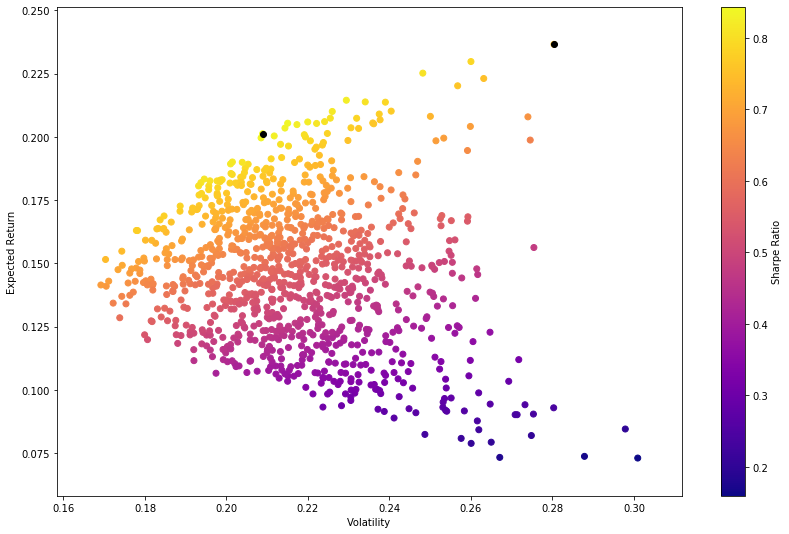

In [348]:
montecarlo_sharpe_optim(['MS','AMZN','XLV','XLY'],1000)